In [117]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

# 1. Load Data

## 1.1 Load Data

In [118]:
# load data
train = pd.read_csv('/Users/pliu/Downloads/all/train.csv')
test = pd.read_csv('/Users/pliu/Downloads/all/test.csv')
train.shape # (1460, 81)
test.shape # (1459, 80)

(1459, 80)

In [119]:
# have a look at the dataset
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1.2 Set Benchmark for Modelling

In [120]:
# calculate benchmark for modelling
# predict simply by median or mean of the target var in training dataset
# this provides a starting point to measure how great the model performs
# to note 0.4 of log-RMSE could rank top 94% in the leader board (Dec.11 2018)
# log-RMSE

round(np.sqrt(((np.log(train.SalePrice) - np.log(train.SalePrice.median())) ** 2).mean()),2)
# median, log-RMSE: 0.4
round(np.sqrt(((np.log(train.SalePrice) - np.log(train.SalePrice.mean())) ** 2).mean()),2)
# median, log-RMSE: 0.41

0.41

# 2. EDA

## 2.1 Understand Target Variable

In [121]:
# check out the distribution of target var
def normal_distribution_plot(col, df=train):
    """Makes a plot for a specific numerical variable to see how well it fits normal distribution
    Args:
      col: a numerical variable to be plotted
      df: a Pandas DataFrame contains the variable
    Returns:
      None
    """    
    (mu, sigma) = norm.fit(df[col]) # get the fitted parameters used by the function
    print('\n mu = {:.3f} and sigma = {:.3f}'.format(mu, sigma)) # print mean and std of the variable
    
    # plot the distribution
    sns.distplot(df[col], fit=norm)
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best') # add legend, label and title()
    plt.ylabel('Frequency')
    plt.title(col + ' distribution')
    
    # get also the Q-Q plot - Quantile
    fig = plt.figure()
    res = stats.probplot(train[col], plot=plt)
    plt.show()


 mu = 180921.196 and sigma = 79415.292


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


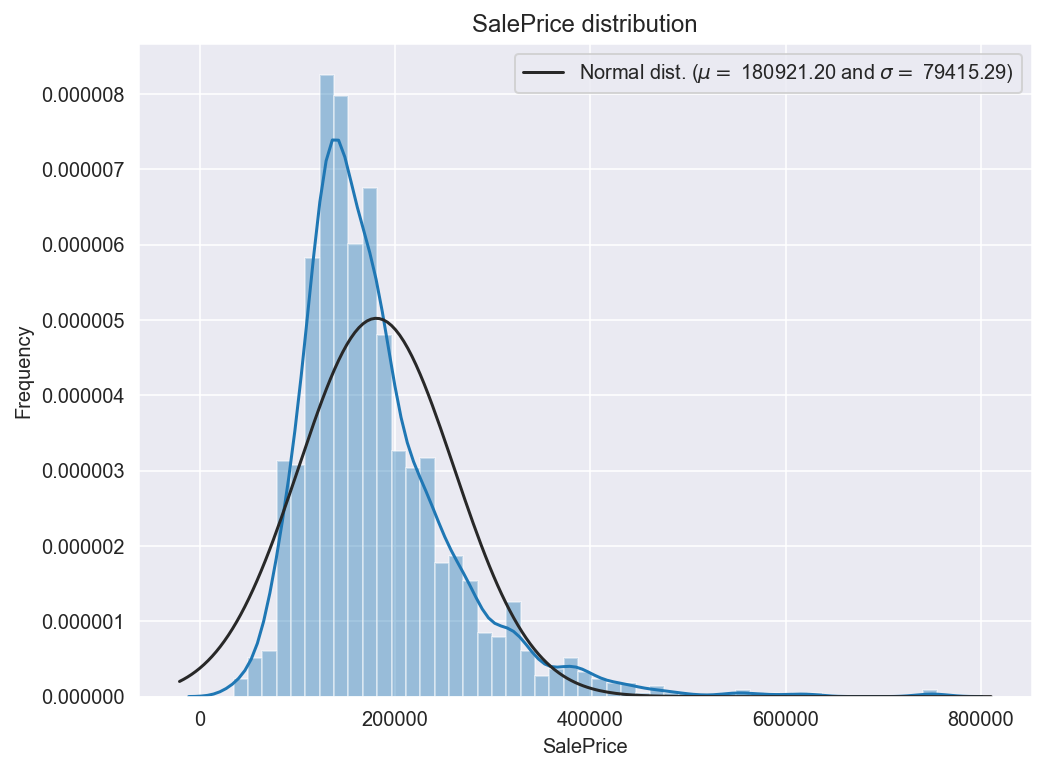

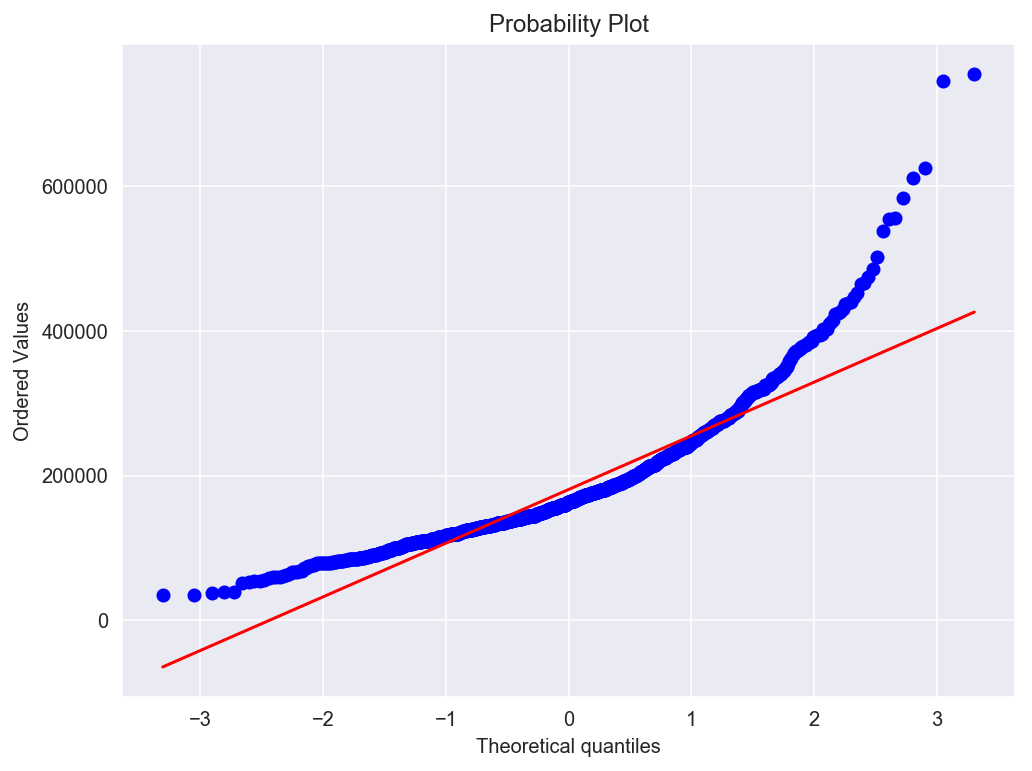

In [122]:
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
normal_distribution_plot('SalePrice')
# findings: target var does not follow normal distribution
# rather it has high positive skewness and peakedness

In [123]:
train["SalePrice"].describe() 
# findings: no strane values that have property price <= 0 

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

## 2.2 Explore Important Indepent Variables for Modelling

<Figure size 576x432 with 0 Axes>

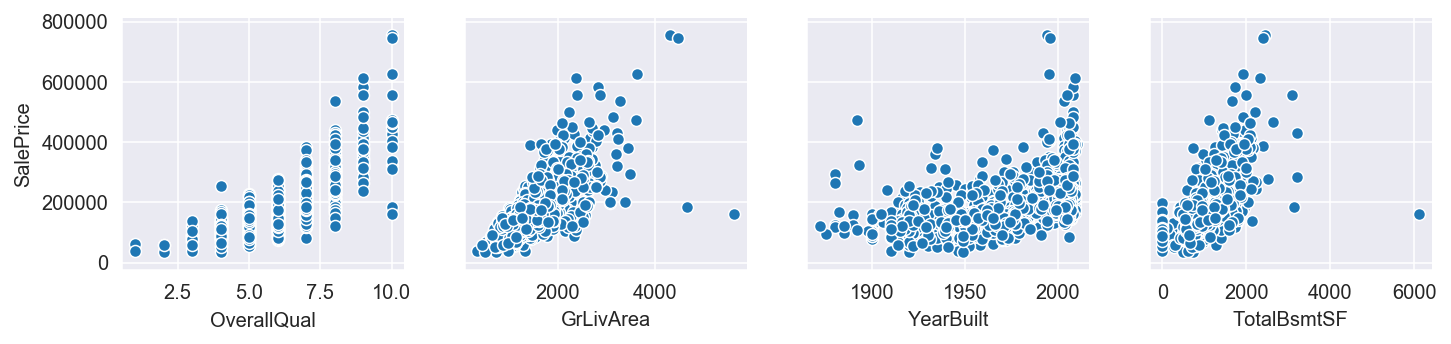

In [124]:
# draw scatter plot to find some patterns and outliers from selected important variables

figure=plt.figure()
imp_vars = ['OverallQual','GrLivArea', 'YearBuilt','TotalBsmtSF']
sns.pairplot(x_vars=imp_vars, y_vars=['SalePrice'], data=train, dropna=True)
plt.show()
# findings: OverallQual is a very strong predictor
# GrLivArea has almost linear relationship with the target var, two outliers appear in the right hand side part of the figure
# YearBuilt: from around 70's onwardsm newly-built houses/apartments have higher price
# TotalBsmtSF: lots of properties have no basement (TotalBsmtSF=0) on the left side of the figure, some outliers appeared

In [125]:
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index,inplace=True)
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index,inplace=True)
train.drop(train[(train['YearBuilt']<1900) & (train['SalePrice']>400000)].index,inplace=True)
train.drop(train[(train['TotalBsmtSF']>6000) & (train['SalePrice']<200000)].index,inplace=True)
train.reset_index(drop=True, inplace=True)
train.shape

(1456, 81)

## 2.3 Understand Independent Variables

In [126]:
# concat data
all_data = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                     test.loc[:, 'MSSubClass':'SaleCondition']))
# concat vertically
all_data.shape
all_data.reset_index(drop=True, inplace=True)

In [127]:
all_data.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2910,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2911,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2912,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2913,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
2914,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [128]:
# check what types of data we have
# count of variable types
def data_type_statistics(df=all_data):
    df_types = pd.DataFrame(df.dtypes)
    df_types.columns = ['type']
    print(df_types.type.value_counts())

data_type_statistics()
# findings: more than half (43/79) are categorical while 36 of 79 are numerical vars

object     43
int64      25
float64    11
Name: type, dtype: int64


In [129]:
df_types[df_types.type=='int64']
# findings: some vars have type of int are actually categorical, e.g. OverallCond, YearBuilt
# need to adjust their type as object later - see Feature Engineering

,type
MSSubClass,int64
LotArea,int64
OverallQual,int64
OverallCond,int64
YearBuilt,int64
YearRemodAdd,int64
1stFlrSF,int64
2ndFlrSF,int64
LowQualFinSF,int64
GrLivArea,int64


# 3. Feature Engineering

## 3.1 log transform target var and plot


 mu = 12.023 and sigma = 0.399


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


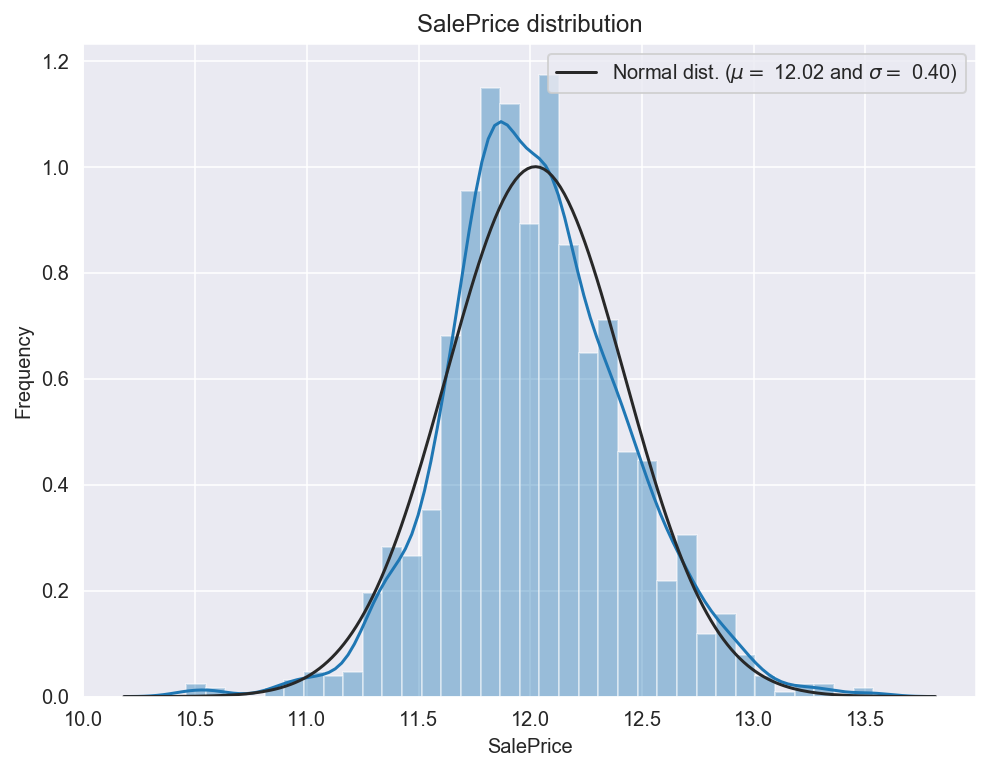

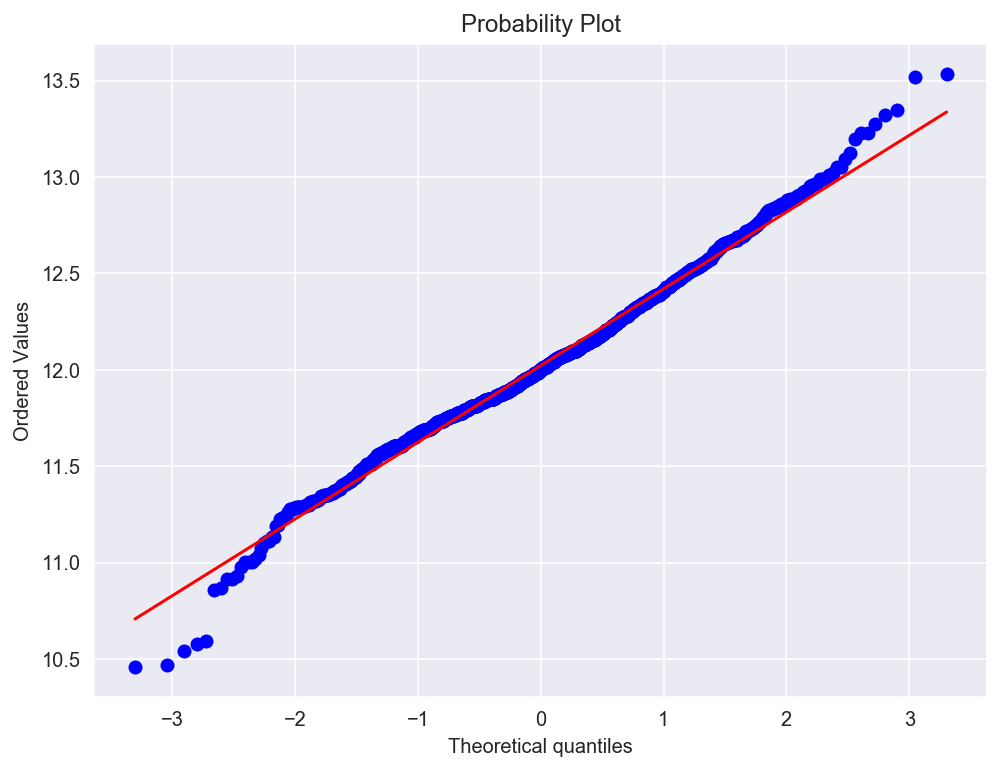

In [130]:
# for the sake of liner models
# use np.log1p(x) instead of np.log(x) b/c some cols many contain 0
train["SalePrice"] = np.log1p(train["SalePrice"])
normal_distribution_plot('SalePrice')
# after transformation the target looks more normally distributed

## 3.2 Missing Value Input

### 3.2.1 Missing Value Overview

In [131]:
# Missing value statistics
def missing_data(df=all_data):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data = missing_data()
missing_data.head(20)

,Total,Percent
PoolQC,2906,0.996913
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
LotFrontage,485,0.166381
GarageCond,159,0.054545
GarageQual,159,0.054545
GarageYrBlt,159,0.054545
GarageFinish,159,0.054545


In [132]:
# create a col to record missing value per row before missing value processing
all_data['missing_per_row'] = all_data.isnull().sum(axis=1)
all_data['missing_per_row'].value_counts()

4     1267
5      992
3      266
6      122
10     114
9       64
2       30
11      17
7       14
15      10
8        9
14       3
12       3
1        2
13       1
16       1
Name: missing_per_row, dtype: int64

In [133]:
train['missing_per_row'] = train.isnull().sum(axis=1)
train['missing_per_row'].value_counts()

4     634
5     500
3     130
10     60
6      58
9      32
2      16
11      7
8       5
7       5
15      4
14      3
1       2
Name: missing_per_row, dtype: int64

In [134]:
# plot cate and target
def plot_box(x, y, df=train, figsize=(8,6)):
    data = pd.concat([df[x], df[y]], axis=1)
    f, ax = plt.subplots(figsize=figsize)
    fig = sns.boxplot(x=x, y=y, data=data)
    fig.axis(ymin=0)

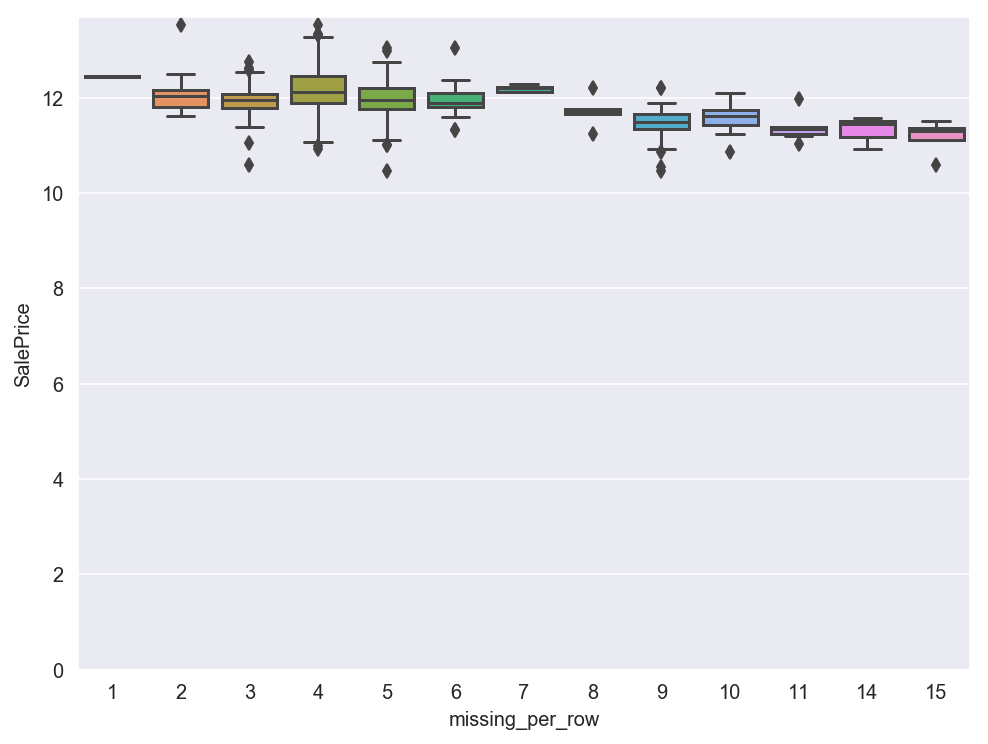

In [135]:
plot_box('missing_per_row', 'SalePrice')

In [136]:
# Missing Data Visualization
def missing_plot(all_data=all_data):
    all_data_na = (all_data.isnull().sum()) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
    f, ax = plt.subplots(figsize=(15, 12)) # set figure size
    plt.xticks(rotation='90') # x labels display vertically
    sns.barplot(x=all_data_na.index, y=all_data_na) # init a sns.barplot(x=, y=)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percentage of missing values', fontsize=15)
    plt.title('Percentage of missing data by feature', fontsize=15)

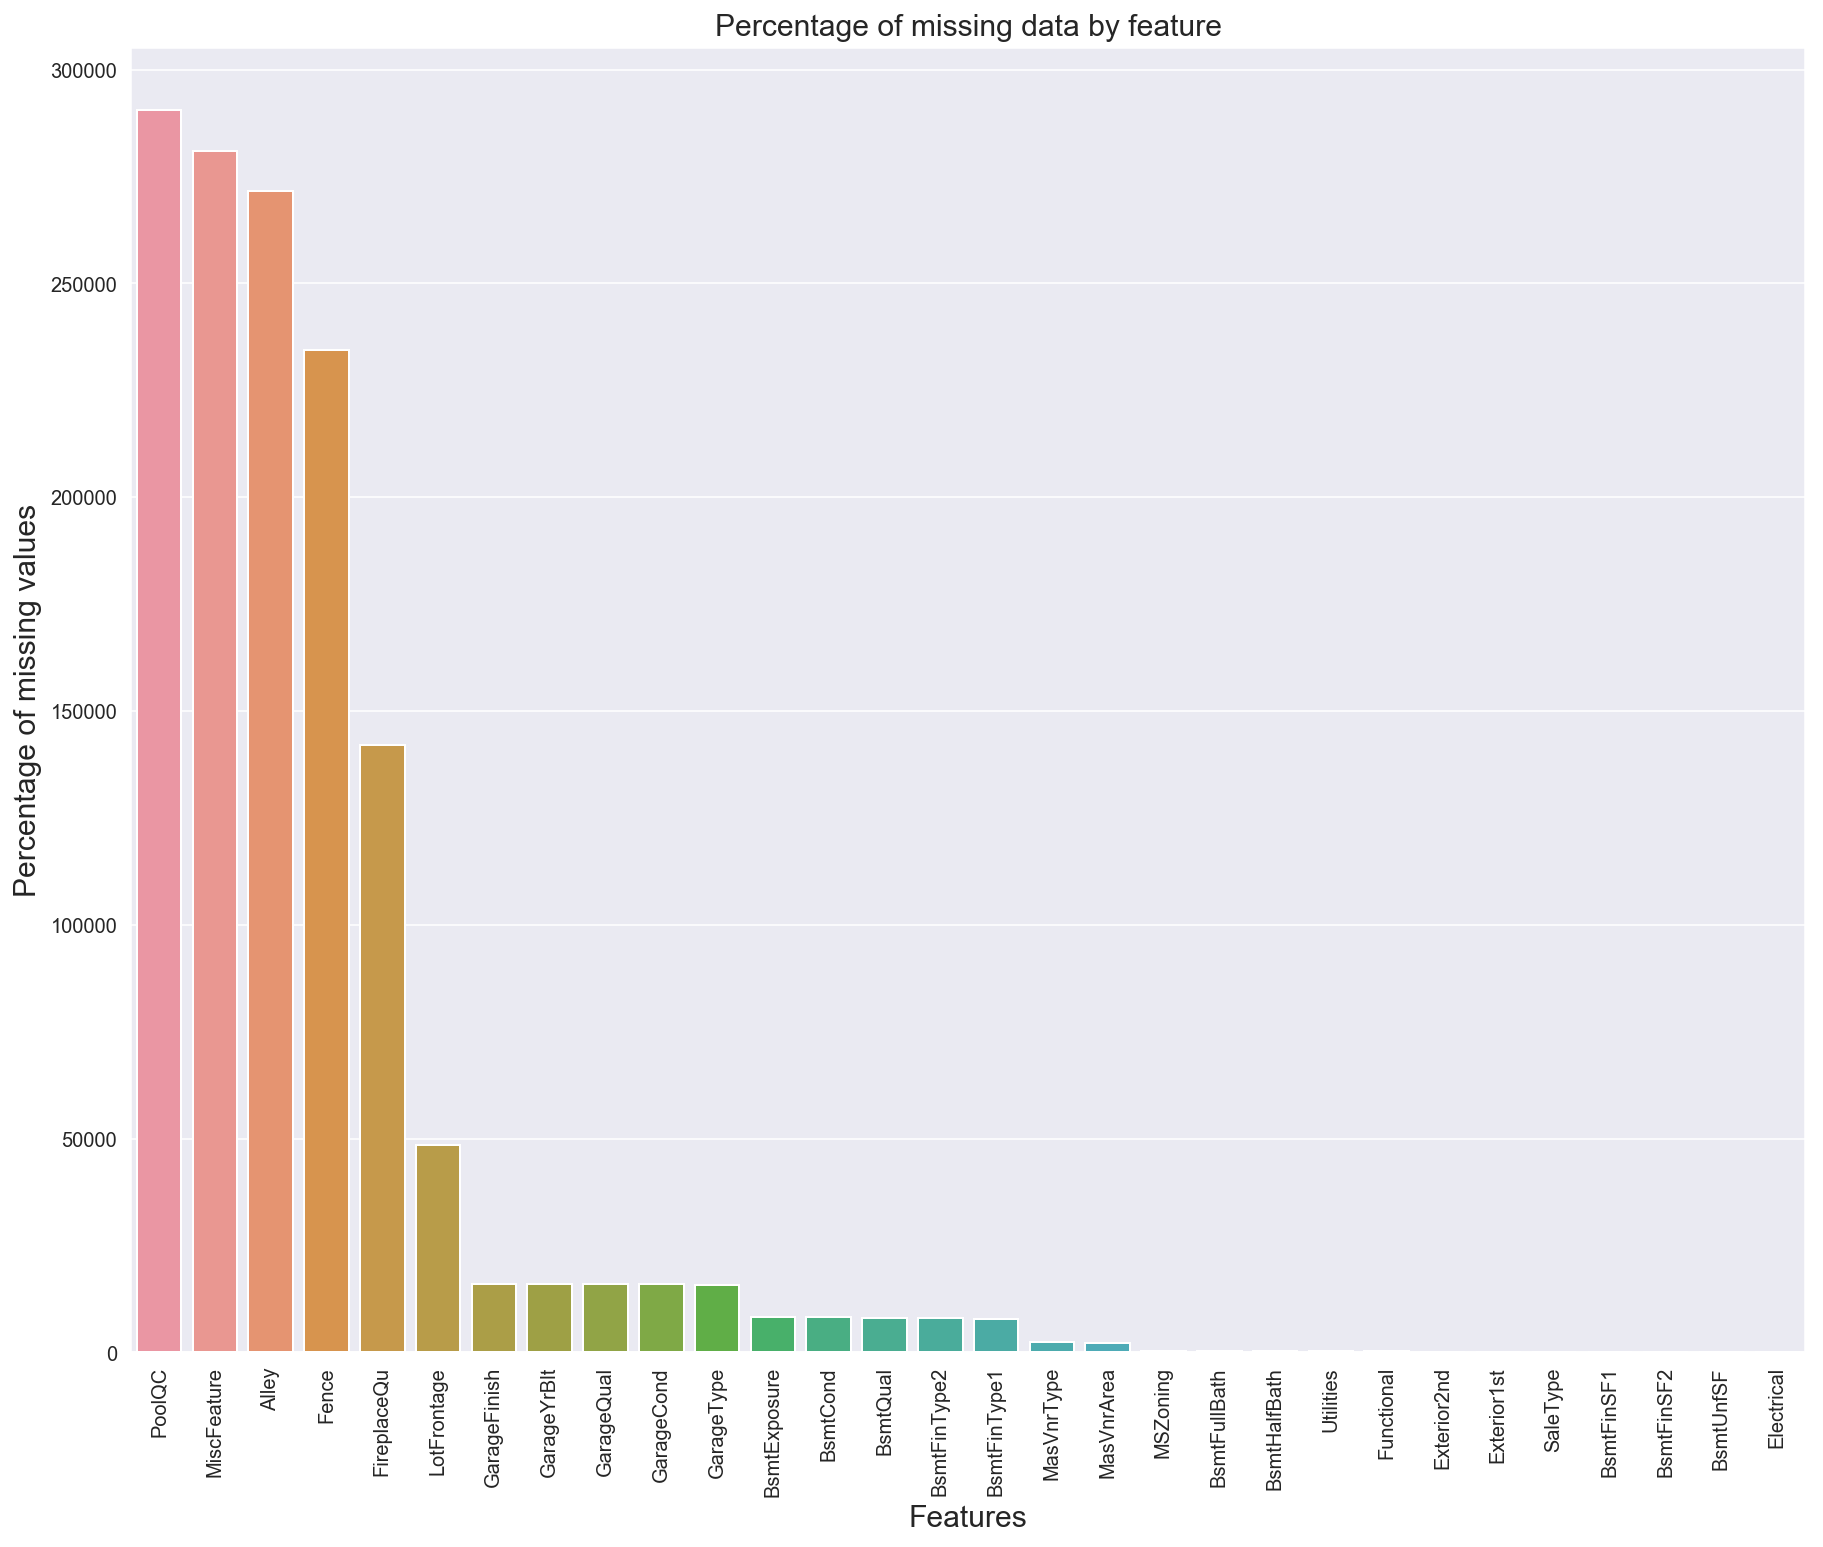

In [137]:
missing_plot()

# 3.2.2 input missing data by 'None'

In [138]:
#  in accordance with the data description
# input  according to description
by_None = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 
           'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure',
           'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass']
for col in by_None:
    all_data[col] = all_data[col].fillna('None')

# 3.2.3 input missing data by group median

In [139]:
# group by and input by median
# fillin missing values by the median of LotFrontage in the Neighborhood
# made a mistake here
#all_data['LotFrontage'] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median))
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# 3.2.4 input missing data by 0

In [140]:
# replace by a number
by_Zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
           'BsmtFullBath', 'BsmtHalfBath']
for col in by_Zero:
    all_data[col] = all_data[col].fillna(0)

# 3.2.5 input missing data by column mode

In [141]:
# replace by Mode
by_Mode = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'MasVnrArea']

for col in by_Mode:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# 3.2.6 remove feature has NA and would not help in predicting

In [150]:
const_cols = [c for c in all_data.columns if all_data[c].nunique(dropna=False)==1 ]
const_cols
#all_data.Utilities.isnull().sum()
all_data.Utilities.value_counts().index[0]

'AllPub'

In [151]:
all_data.drop('Utilities', inplace=True, axis=1)

# 3.2.7 others

In [152]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [153]:
# check remaining missing values
all_data_na = (all_data.isnull().sum()/len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
all_data_na
# findings: all clean

Series([], dtype: float64)

## 3.3 Numerical to Categorical

In [154]:
# as long as col has a type of string, pandas will treat it as categorical var
for col in ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']:
    all_data[col] = all_data[col].astype(str)

# check after data type modification
data_type_statistics()
# 46 vs. 43 categorical vars (Utilities is removed)

object     46
int64      22
float64    11
Name: type, dtype: int64


## 3.4 Add Feature

In [155]:
# add one derived feature
all_data['Total_SQ'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

## 3.5 Encoding Ordinary variable

In [156]:
# LabelEncoder cannot regconize the differences of orders
# create a custom func to map types of ordinary var in str into int
# and then apply this map func to all ordinary columns in a loop
def ordinary_mapping(ins):
    if ins=='Ex': # Excellent
        res=0
    elif ins=='Gd': # Good
        res=1
    elif ins=='TA': # Average/Typical
        res=2
    elif ins=='Fa': # Fair
        res=3
    elif ins=='Po': # Poor
        res=4
    else: # e.g. None, NA
        res=5
    return res

In [157]:
# some other ordinary var do not fall into this mapping
all_data.BsmtFinType1.value_counts()

Unf     850
GLQ     847
ALQ     429
Rec     288
BLQ     268
LwQ     154
None     79
Name: BsmtFinType1, dtype: int64

In [158]:
to_be_mapped = ['ExterQual', 'ExterCond', 'KitchenQual', 'HeatingQC',
                'BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'PoolQC']

for col in to_be_mapped:
    all_data[col] = all_data[col].apply(ordinary_mapping)

In [159]:
# examine
all_data.BsmtQual.value_counts()

2    1282
1    1208
0     256
3      88
4      81
Name: BsmtQual, dtype: int64

## 3.6 Add Nice Attribute Features

In [170]:
# if a property owns a specific nice feature that could increase the its value
nice_features = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
for col in nice_features:
    all_data['HasNo'+col] = (all_data[col] == 0) * 1

In [172]:
# examine
all_data.WoodDeckSF.value_counts() # 0      1522
all_data.HasNoWoodDeckSF.value_counts() # 1    1522

1    1522
0    1393
Name: HasNoWoodDeckSF, dtype: int64

In [41]:
train_high_var = train.loc[:,train.apply(pd.Series.nunique) != 1]
train_high_var.shape

(1460, 81)

In [43]:
all_data.std()

MSSubClass         42.517628
LotFrontage        23.344905
LotArea          7886.996359
OverallQual         1.409947
OverallCond         1.113131
YearBuilt          30.291442
YearRemodAdd       20.894344
MasVnrArea        179.334253
BsmtFinSF1        455.610826
BsmtFinSF2        169.205611
BsmtUnfSF         439.543659
TotalBsmtSF       440.766258
1stFlrSF          392.362079
2ndFlrSF          428.701456
LowQualFinSF       46.396825
GrLivArea         506.051045
BsmtFullBath        0.524736
BsmtHalfBath        0.245687
FullBath            0.552969
HalfBath            0.502872
BedroomAbvGr        0.822693
KitchenAbvGr        0.214462
TotRmsAbvGrd        1.569379
Fireplaces          0.646129
GarageYrBlt        25.574285
GarageCars          0.761624
GarageArea        215.394815
WoodDeckSF        126.526589
OpenPorchSF        67.575493
EnclosedPorch      64.244246
3SsnPorch          25.188169
ScreenPorch        56.184365
PoolArea           35.663946
MiscVal           567.402211
MoSold        

In [45]:
train.Utilities.describe()

count       1460
unique         2
top       AllPub
freq        1459
Name: Utilities, dtype: object